In [37]:
#Importing Libaries
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

import matplotlib
import seaborn as sns


In [38]:
#Importing data and describe it
df = pd.read_csv("data/COGS.csv", delimiter=";", decimal=",")
df.columns = ['year','COGS']
df.head(3)
df.describe()

,COGS
count,93.000000
mean,-597.623656
std,283.125641
min,-1331.000000
25%,-791.000000
50%,-549.000000
75%,-365.000000
max,-197.000000


In [39]:
print('Time period start: {}\nTime period end: {}'.format(df.year.min(),df.year.max()))

Time period start: 2015-01
Time period end: 2022-09


In [40]:
df.columns

Index(['year', 'COGS'], dtype='object')

In [41]:
#Converting to datetime format:
df['year'] = pd.to_datetime(df['year'], format='%Y-%m')

In [42]:
#Setting index as the datetime column for easier manipulations: 
y = df.set_index('year')
y.index 

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
     

In [43]:
y.isnull().sum()

COGS    0
dtype: int64

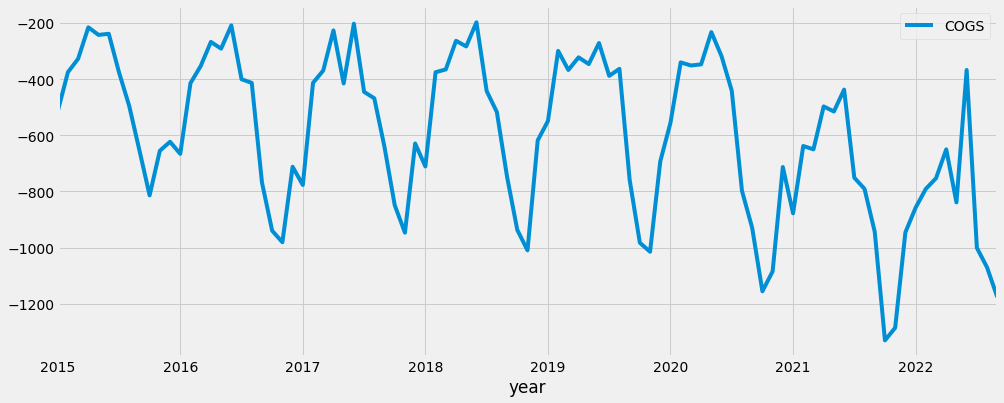

In [44]:
#Visualize the data imported
y.plot(figsize=(15, 6))
plt.show()

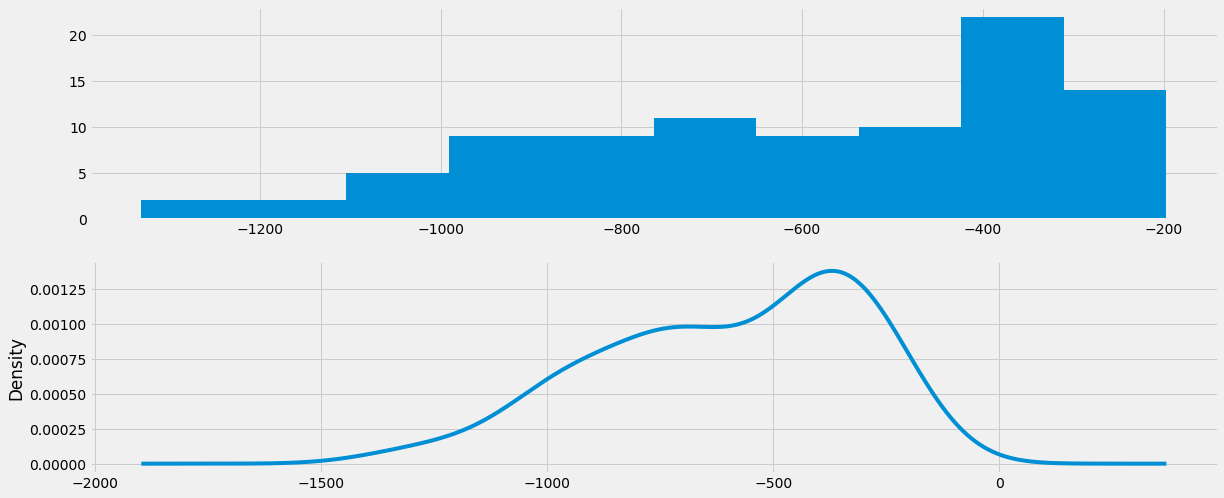

In [46]:
#Reviewing plots of the density of observations can provide further insight into the structure of the data: 
#The distribution is is illustrated whether it is normal distributed
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
y.COGS.hist()
pyplot.subplot(212)
y.COGS.plot(kind='kde')
pyplot.show()

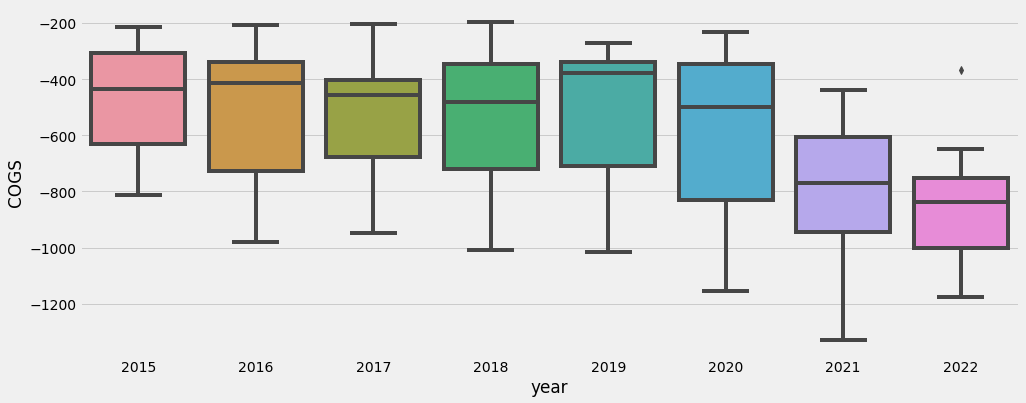

In [47]:
#Box and Whiskers Plots
#Median values across years confirms and upwards trend

fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(y.COGS.index.year, y.COGS, ax=ax)

In [48]:
#Decomposing using statsmodel
#The decomposition of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories patterns. 
#With statsmodels it is able to see the trend, seasonal, and residual components of the data. 
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
plt.show()


ValueError: Multiplicative seasonality is not appropriate for zero and negative values

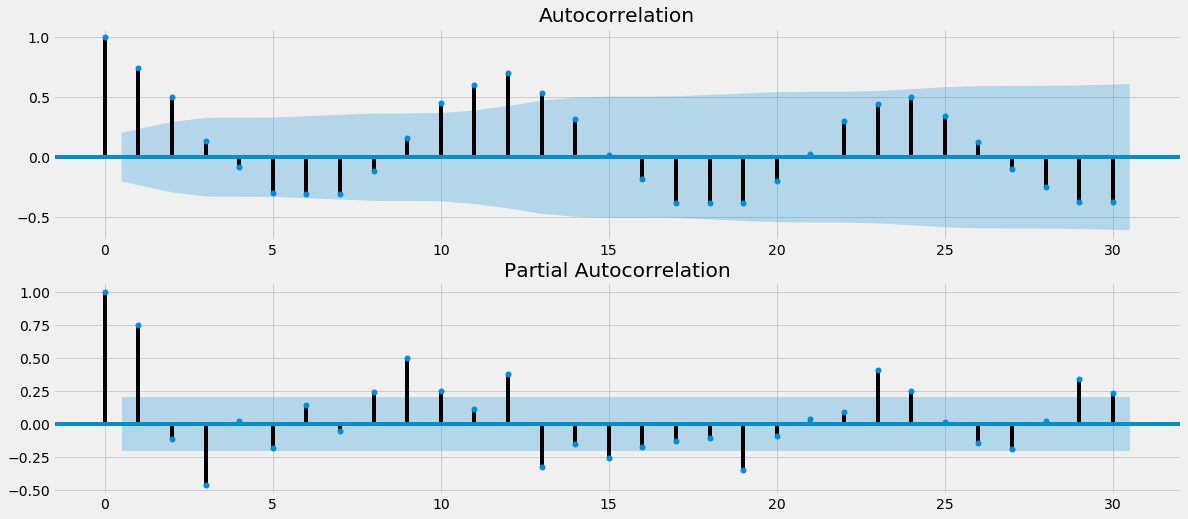

In [49]:
#Stationarity 
#A time series is said to be stationary if its statistical properties such as mean and variance remain cosntant over time. 
#Most of the Time Series models work on the assumption that the TS is stationary. Major reason for this is that there are many ways in which a series can be non-stationary, but only one way for stationarity.
#Intuitively, we can say that if a Time Series has a particular behaviour over time, there is a very high probability that it will follow the same in the future.

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(y.COGS, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(y.COGS, ax=pyplot.gca(), lags = 30)
pyplot.show()

#ACF and PACF plots: If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.
#Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. Moving average/variance is for any instant ‘t’, the average/variance of the last year, i.e. last 12 months.
#Augmented Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.


In [50]:
#Augmented Dickey-Fuller Test & Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(y.COGS, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)


Results of Dickey-Fuller Test:
Test Statistic                  2.754368
p-value                         1.000000
#Lags Used                     11.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


In [51]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [52]:
#ARIMA 
#In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

#Number of AR (Auto-Regressive) terms (p): p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
#Number of Differences (d): d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.
#Number of MA (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.


ts = y.COGS - y.COGS.shift()
ts.dropna(inplace=True)

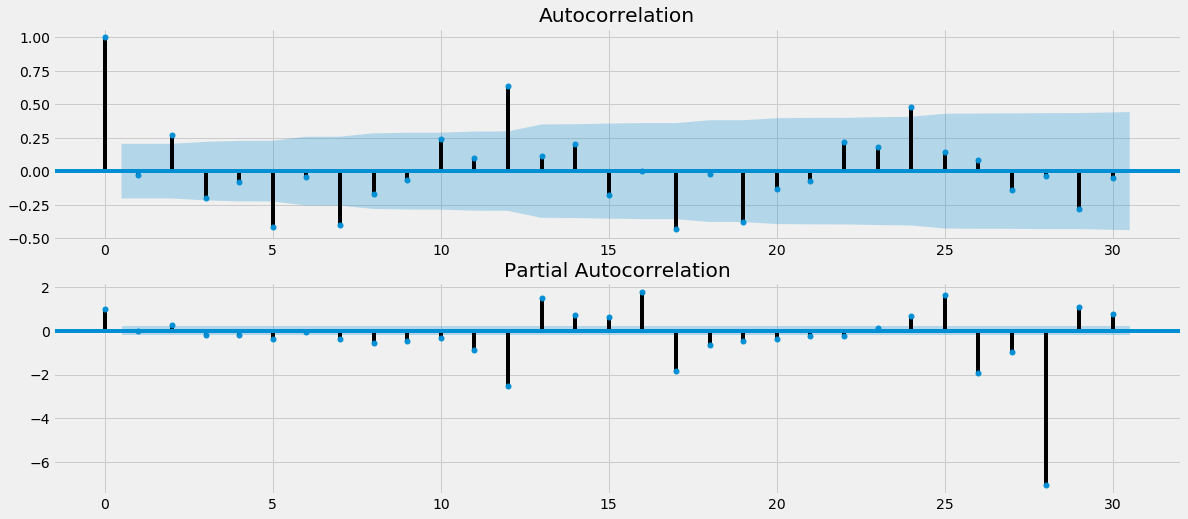

In [53]:
#ACF and PACF plots after differencing:
pyplot.figure()
pyplot.subplot(211)
plot_acf(ts, ax=pyplot.gca(),lags=30)
pyplot.subplot(212)
plot_pacf(ts, ax=pyplot.gca(),lags=30)
pyplot.show()

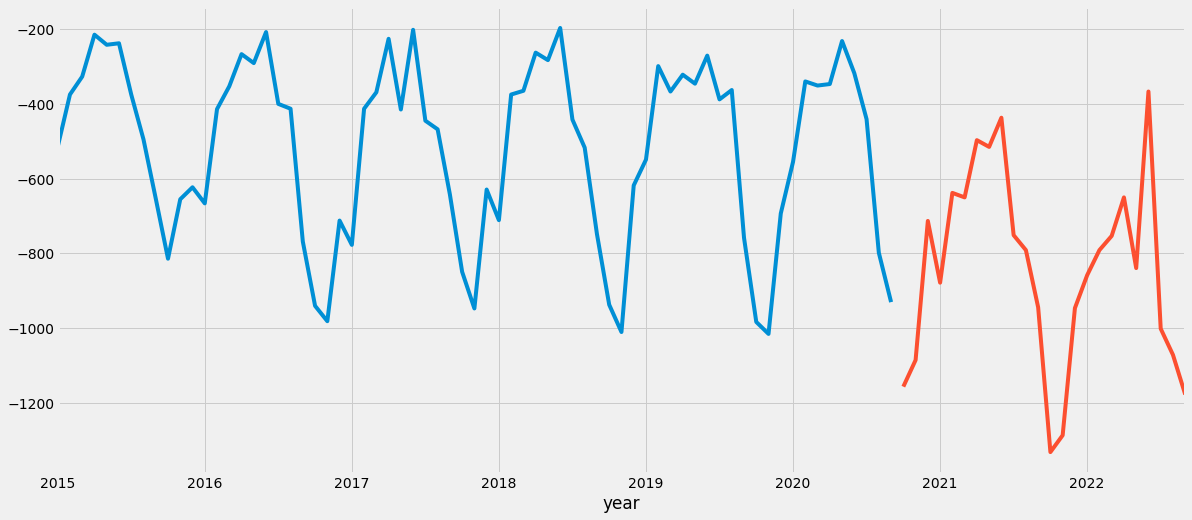

In [54]:
#divide into train and validation set
train = y[:int(0.75*(len(y)))]
valid = y[int(0.75*(len(y))):]

#plotting the data
train['COGS'].plot()
valid['COGS'].plot()

In [55]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# fit model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit(disp=1)

In [56]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.COGS   No. Observations:                   68
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -446.751
Method:                       css-mle   S.D. of innovations            172.555
Date:                Mon, 24 Oct 2022   AIC                            901.503
Time:                        11:13:19   BIC                            910.381
Sample:                    02-01-2015   HQIC                           905.020
                         - 09-01-2020                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -6.3671     26.391     -0.241      0.809     -58.092      45.358
ar.L1.D.COGS     0.4413      0.256      1.722      0.085      -0.061       0.944
ma.L1.D.COGS    -0.2916      0.249     -1.172      0.241      -0.779       0.196
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.2660           +0.0000j            2.2660            0.0000
MA.1            3.4295           +0.0000j            3.4295            0.0000
-----------------------------------------------------------------------------
"""

In [67]:
#SARIMA Modeling
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [68]:
min_aic = 999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            #Check for best model with lowest AIC
            if results.aic < min_aic:
                min_aic = results.aic
                min_aic_model = results
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1057.3038860706074
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:876.1654072410691
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:680.0720924350338
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:525.7295010634299
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:692.5690803532623
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:672.5772639988146
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:538.7353524819987
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:525.6248533534744
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:987.5032217059118
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:819.3250815550838
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:664.0614370800251
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:513.4049682997934
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:688.8647343685875
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:660.1787630833948
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:537.613716247327
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:513.9045240095279
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:884.6026385120531
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:705.2788297497086
ARIMA(0, 1

In [69]:
min_aic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               COGS   No. Observations:                   69
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -250.129
Date:                            Mon, 24 Oct 2022   AIC                            506.257
Time:                                    11:15:47   BIC                            511.470
Sample:                                01-01-2015   HQIC                           508.168
                                     - 09-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7025      0.193     -3.649      0.000      -1.080      -0.325
ma.S.L12      -0.4131      0.247     -1.675      0.094      -0.896       0.070
sigma2      8641.4494   1615.260      5.350      0.000    5475.598    1.18e+04
===================================================================================
Ljung-Box (Q):                       47.55   Jarque-Bera (JB):                27.78
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               3.15   Skew:                            -0.90
Prob(H) (two-sided):                  0.04   Kurtosis:                         6.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [72]:
#Period for forecast
start_analysis = "2017-01-01"
end_analysis = "2025-12-31"

#Predictions
pred = min_aic_model.get_prediction(start=start_analysis,end=end_analysis, dynamic=False)

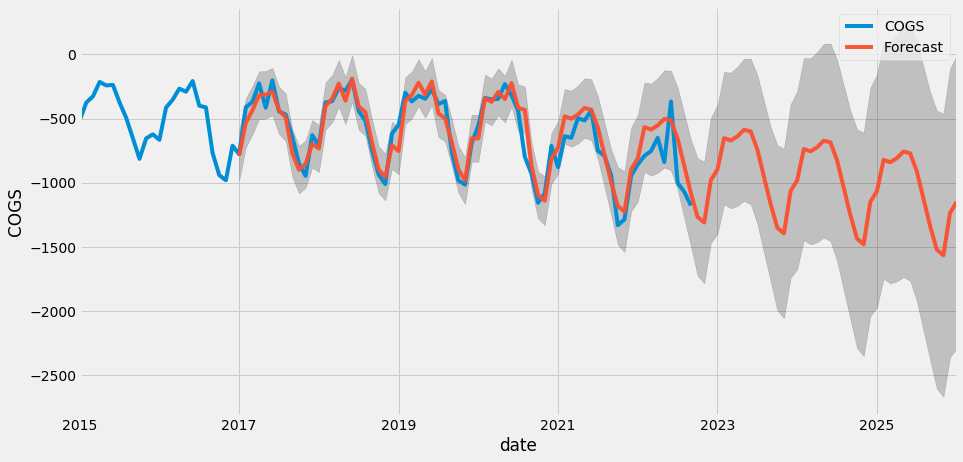

2017-01-01    -789.169224
2017-02-01    -533.258606
2017-03-01    -434.913030
2017-04-01    -318.623417
2017-05-01    -314.956220
                 ...     
2025-09-01   -1335.834789
2025-10-01   -1520.310343
2025-11-01   -1564.753337
2025-12-01   -1235.500921
2026-01-01   -1149.948945
Freq: MS, Length: 109, dtype: float64
             lower COGS  upper COGS
2017-01-01  -986.194169 -592.144279
2017-02-01  -724.733318 -341.783894
2017-03-01  -622.601252 -247.224808
2017-04-01  -504.617242 -132.629593
2017-05-01  -500.150694 -129.761746
...                 ...         ...
2025-09-01 -2378.759551 -292.910027
2025-10-01 -2602.376500 -438.244186
2025-11-01 -2667.635941 -461.870733
2025-12-01 -2358.814275 -112.187566
2026-01-01 -2293.328058   -6.569832

[109 rows x 2 columns]


In [73]:
pred_ci = pred.conf_int()
ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.95, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('date')
ax.set_ylabel('COGS')
plt.legend()
plt.show()

print(pred.predicted_mean)
print(pred_ci)

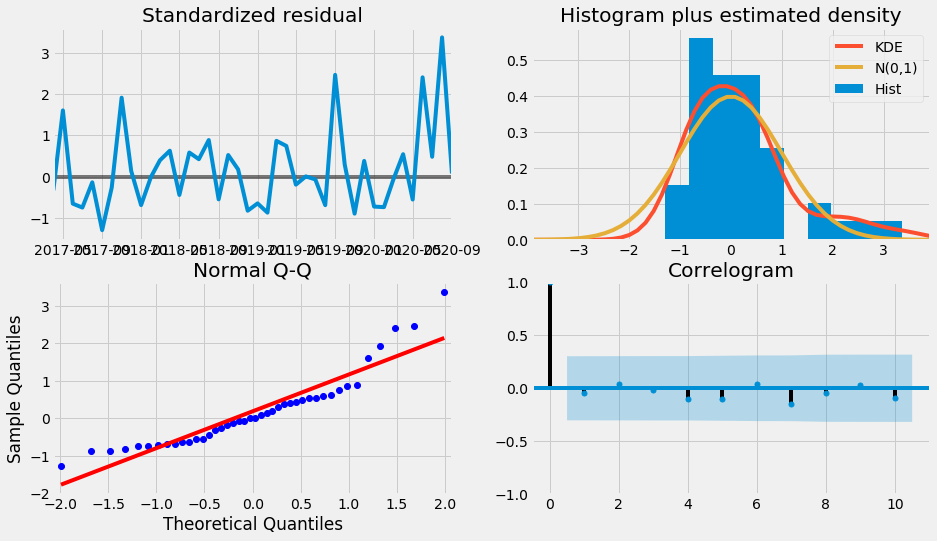

In [25]:
results.plot_diagnostics(figsize=(14, 8))
plt.show()

In [26]:
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [27]:
#Evaluate Forecast
y_forecasted = pred.predicted_mean.values
y_truth = y[start_analysis:end_analysis].revenue.values
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

AttributeError: 'DataFrame' object has no attribute 'revenue'

In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 224.59


In [ ]:
evaluate_forecast(y_truth, y_forecasted)

NameError: name 'y_truth' is not defined